# 探索淘宝用户行为数据集



## 目录
- [简介](#intro)
- [I - 提出问题](#question)
- [II - 收集数据](#data_collect)
- [III - 整理数据](#data_wrangle)
- [IV - 探索性数据分析](#EDA)
- [V - 结论](#conclusion)
- [VI - 反思](#introspection)
<a id='intro'></a>
## 简介

    1、数据集描述

    数据集包含了2017年11月25日至2017年12月3日之间，有行为的约一百万随机用户的所有行为（行为包括点击、购买、加购、喜欢）。每一行表示一条用户行为，由用户ID、商品ID、商品类目ID、行为类型和时间戳组成，并加以逗号分割。

    2、内容
    
    对用户浏览行为的时间规律及用户行为的转化情况进行了探索。

<a id='problem'></a>

## 提出问题

### 1、用户浏览行为有何时间规律？

### 2、用户行为的转化情况如何？
<a id='data_collect'></a>

## 收集数据

数据集已从阿里云天池下载至本地，为csv格式。

In [1]:
# 导入包
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pyecharts.charts import Funnel, Bar, Line, Page, Boxplot
from pyecharts import options as opts
    
%matplotlib inline

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# 导入数据集
df = pd.read_csv('UserBehavior.csv', header = None, names = ["User ID", "Item ID", "Category ID", 
                                                                             "Behavior type", "Timestamp"])

In [3]:
# 查看表头
df.head(1)

,User ID,Item ID,Category ID,Behavior type,Timestamp
0,1,2268318,2520377,pv,1511544070


<a id='data_wrangle'></a>

## 整理数据

### 一、评估数据

In [4]:
# 查看数据集列的具体信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100150807 entries, 0 to 100150806
Data columns (total 5 columns):
User ID          int64
Item ID          int64
Category ID      int64
Behavior type    object
Timestamp        int64
dtypes: int64(4), object(1)
memory usage: 3.7+ GB


In [5]:
# 查看有无缺失值
df.isnull().any()

User ID          False
Item ID          False
Category ID      False
Behavior type    False
Timestamp        False
dtype: bool

In [6]:
# 拷贝数据集
df_clean = df.copy()

#### 质量

- Timestamp列数据类型应为datetime
- Timestamp列的日期应在2017年11月25日至2017年12月3日之间

### 二、清理数据

#### 质量

- Timestamp列数据类型应为datetime，根据探索问题需单独提取日期及小时信息
- Timestamp列的日期应在2017年11月25日至2017年12月3日之间

##### 定义

- 将Timestamp列数据类型调整为datetime，新增Date列显示年、月、日信息，新增Hour列显示小时信息。
- 清理2017年11月25日至2017年12月3日外的数据行

##### 代码

In [7]:
# 将Timestamp列数据类型调整为datetime
df_clean['Timestamp'] = df_clean['Timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))

In [8]:
# 新增Date列显示年、月、日信息
df_clean['Date'] = df_clean['Timestamp'].apply(lambda y: y.strftime("%Y-%m-%d"))

In [9]:
# 新增Hour列显示小时信息
df_clean['Hour'] = df_clean['Timestamp'].dt.hour

In [10]:
# 查看有无2017年11月25日至2017年12月3日外的日期
df_clean['Date'].value_counts()[:15]

2017-12-02    13777869
2017-12-03    13662159
2017-12-01    10859436
2017-11-26    10664602
2017-11-30    10447740
2017-11-25    10420015
2017-11-29    10284073
2017-11-27    10101147
2017-11-28     9878190
2017-11-24       40231
2017-11-23        4664
2017-11-22        1546
2017-12-04         825
2017-11-21         743
2017-11-19         647
Name: Date, dtype: int64

In [11]:
# 清理2017年11月25日至2017年12月3日外的数据行
df_clean = df_clean[df_clean["Date"] <= '2017-12-03']
df_clean = df_clean[df_clean['Date'] >= '2017-11-25']

##### 检验

In [12]:
df_clean.head()

,User ID,Item ID,Category ID,Behavior type,Timestamp,Date,Hour
0,1,2268318,2520377,pv,2017-11-25 01:21:10,2017-11-25,1
1,1,2333346,2520771,pv,2017-11-25 06:15:33,2017-11-25,6
2,1,2576651,149192,pv,2017-11-25 09:21:25,2017-11-25,9
3,1,3830808,4181361,pv,2017-11-25 15:04:53,2017-11-25,15
4,1,4365585,2520377,pv,2017-11-25 15:49:06,2017-11-25,15


In [13]:
df_clean['Date'].value_counts()

2017-12-02    13777869
2017-12-03    13662159
2017-12-01    10859436
2017-11-26    10664602
2017-11-30    10447740
2017-11-25    10420015
2017-11-29    10284073
2017-11-27    10101147
2017-11-28     9878190
Name: Date, dtype: int64

In [14]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100095231 entries, 0 to 100150806
Data columns (total 7 columns):
User ID          int64
Item ID          int64
Category ID      int64
Behavior type    object
Timestamp        datetime64[ns]
Date             object
Hour             int64
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 6.0+ GB


<a id='EDA'></a>

## 探索性数据分析

### 1、用户浏览行为有何时间规律？

In [15]:
# 建立用户浏览量数据集
df_clean_pv = df_clean[df_clean['Behavior type'] == 'pv']

# 检验数据集正确性
df_clean_pv['Behavior type'].value_counts()

pv    89660688
Name: Behavior type, dtype: int64

In [30]:
# 查看每日浏览量情况
pv_group = df_clean_pv.groupby(['Date'])['User ID'].count()

line = (
    Line(init_opts = opts.InitOpts(width="980px"))
    .add_xaxis(pv_group.index.tolist())
    .add_yaxis("浏览量",pv_group.tolist())
)
line.load_javascript()
line.render()
line.render_notebook()

11月25日至12月3日为周六至次周周日共9天的数据，从用户浏览日分布情况来看，12月2日（周六）、12月3日（周日）的浏览量较大，但同时应注意到11月25日（周六）、11月26日（周日）的浏览量并不高，暂时不能确定浏览量增加与周末有关，日浏览量可能受访客数、访客浏览量影响。

In [17]:
# 查看每日访客情况
uv_group = df_clean_pv.drop_duplicates(subset = ['Date','User ID']).groupby(['Date'])['User ID'].count()

line = (
    Line(init_opts = opts.InitOpts(width="980px"))
    .add_xaxis(uv_group.index.tolist())
    .add_yaxis("访客数量",uv_group.tolist())
)
    
line.render_notebook()

可以看出，12月2日和12月3日的访客数较之前有所增加，因此12月2日和12月3日浏览量增加的因素之一为访客数增加。

In [31]:
# 查看访客平均浏览量
mean_pv = pv_group/uv_group 
mean_pv = mean_pv.apply(lambda a : round(a,2))

line = (
    Line(init_opts = opts.InitOpts(width="980px"))
    .add_xaxis(mean_pv.index.tolist())
    .add_yaxis("访客平均浏览量",mean_pv.tolist())
)
    

line.render_notebook()

可以看出，访客平均浏览量13左右，波动较小，因此12月2日和12月3日浏览量较大的因素为访客增加。

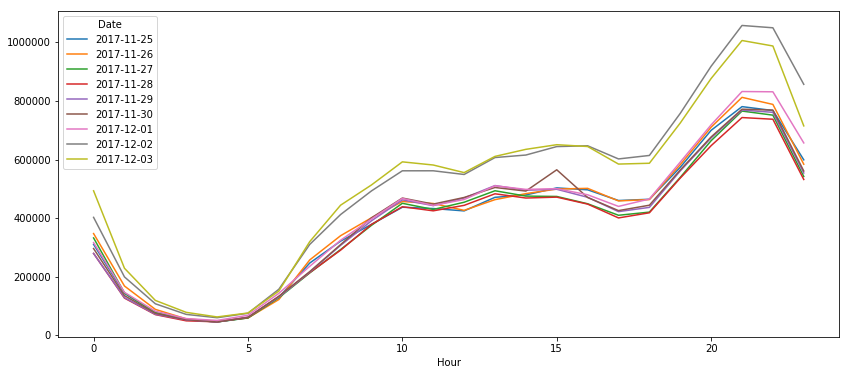

In [33]:
# 用户每小时浏览网站分布情况（每日）
df_clean_pv.groupby(['Hour'])['Date'].value_counts().unstack().plot(figsize = (14,6));

可以看出，用户主要在晚上最为活跃，凌晨时段的活跃度最低，从各天的情况看，用户每日的活跃时段较为稳定，未明显发现受周末因素影响的迹象。

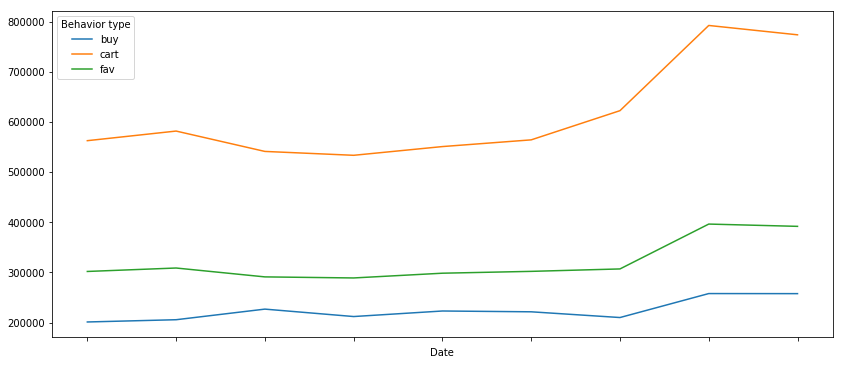

In [20]:
# 查看用户其它行为的分布情况
df_clean[df_clean['Behavior type'] != 'pv'].groupby(['Date'])['Behavior type'].value_counts().unstack().plot(figsize = (14,6));

用户的加购物车、收藏、购买行为的频次与浏览频次类似，转化率的变化在探索用户行为转化问题时进行分析。

### 2、用户行为的转化情况如何？

In [21]:
# 查看总体行为情况
df_clean['Behavior type'].value_counts()

pv      89660688
cart     5530446
fav      2888258
buy      2015839
Name: Behavior type, dtype: int64

In [22]:
# 将各行为赋值给相应变量
pv = df_clean['Behavior type'].value_counts()[0]
cart = df_clean['Behavior type'].value_counts()[1]
fav = df_clean['Behavior type'].value_counts()[2]
buy = df_clean['Behavior type'].value_counts()[3]

In [23]:
# 检验
pv

89660688

In [24]:
# 计算转化率
pv_trans = "100%"
cart_fav_trans = str(round((cart + fav) / pv * 100, 3)) + "%"
buy_trans = str(round(buy / pv * 100, 3)) + "%"

In [25]:
# 检验
cart_fav_trans

'9.39%'

In [26]:
# 绘制漏斗图
funnel = (
    Funnel()
    .add(
        "转化率",
    [["点击率：" + pv_trans, int(pv)],
     ["收藏与加购物车率："+ cart_fav_trans, int(cart + fav)],
     ["购买率：" + buy_trans, int(buy)]])
    .set_global_opts(title_opts=opts.TitleOpts(title="转化率"))
)
funnel.render_notebook()

整体来看，收藏与加购物车转化率为9.39%，购买率为2.25%。

In [27]:
# 生成每日用户行为数量汇总数据集
df_group = df_clean.groupby(['Date'])['Behavior type'].value_counts().unstack()

In [28]:
# 查看数据集
df_group

Behavior type,buy,cart,fav,pv
Date,,,,
2017-11-25,201145,563376,302071,9353423
2017-11-26,205644,582581,308954,9567423
2017-11-27,226835,541904,291221,9041187
2017-11-28,212000,534157,289100,8842933
2017-11-29,223072,551593,298587,9210821
2017-11-30,221463,565015,302264,9358998
2017-12-01,210016,623346,307115,9718959
2017-12-02,257907,793569,396749,12329644
2017-12-03,257757,774905,392197,12237300


In [29]:
# 绘制每日用户行为转化率折线图
pv_fav_cart = round((df_group['fav'] +df_group['cart']) / df_group['pv'],3)
pv_buy = round(df_group['buy'] / df_group['pv'],3)
line = (
    Line(init_opts = opts.InitOpts(width="980px"))
    .add_xaxis(df_group.index.tolist())
    .add_yaxis("购物车与收藏转化率",pv_fav_cart.tolist())
    .add_yaxis("购买转换率", pv_buy.tolist())
)
    
line.render_notebook()

可以看出，购物车与收藏转化率在11月25日至11月30日较为平稳，而购买转换率在11月27日至12月30日较为平稳。11月25日、26日及12月1日-3日的购买转化率较低，同时12月1日-3日的购物车与收藏转化率较高，12月1日起有促销活动预热的概率较大，导致加购物车与收藏转化率升高，购买转化率降低，其次周末的购买转化率较平时低。

<a id='conclusion'></a>

## 结论

### 1、用户浏览行为的时间规律
- 用户在晚上较为活跃，21时-22时活跃度最高，凌晨活跃度较低，推送消息的时间可考虑设置在下午、晚上。
- 在此数据集中未发现用户周末与平时的浏览行为有较大差异。
- 12月2日、3日用户行为频次较之前明显增加，系访客数量增加导致。

### 2、用户行为的转化情况
- 用户的购物车与收藏转化率为9.39%，购买转化率为2.25%， 12月1日起疑似有促销活动预热，导致加购物车与收藏转化率升高，购买转化率降低。其次可发现周末的购买转化率较平时低。

<a id='introspection'></a>

## 反思

- 12月2日、3日用户行为频次较之前有明显增加，初步分析为访客数量增加导致，从各行为数据来看，12月1日起加购物车及收藏转化率有提升，疑似有促销活动预热，但因无活动内容的相关数据，无法进行进一步的分析挖掘。
- 因暂未学习机器学习相关知识，仅就时间维度对用户的行为规律进行了分析，未将用户行为及品类、商品相关联，进一步分析相关用户的商品推荐系统。